# Training an object detection AI model using YOLOv5 with OpenShift Data Science (Part 2)

### Setting up the environment and installing suitable dependencies

In [1]:
!pip install -qr yolov5/requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sahi 0.11.15 requires opencv-python<=4.8, but you have opencv-python 4.8.1.78 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# We must also make sure we have the right version of opencv
# We must run this. Otherwise, the YOLOv5 function cannot run and output "ImportError: libGL.so.1: cannot open shared object file: No such file or directory"
!pip uninstall -qy opencv-python
!pip uninstall -qy opencv-python-headless
!pip install -q opencv-python-headless

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.9 requires opencv-python-headless==4.8.0.74, but you have opencv-python-headless 4.8.1.78 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Here we make sure we are running Nvidia GPU to speed up the process (if appliable)

Make sure your OpenShift cluster has GPU nodes available, otherwise it may take a long time to train the YOLOv5 model if not possible. To learn how to setup GPU machines, please check out the OpenShift documentation and Nvidia Operator website.

In [3]:
import torch

# Check if a CUDA device is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU.")
    device = torch.device('cuda')
else:
    print("CUDA is not available. PyTorch is using CPU.")
    device = torch.device('cpu')

# Print out the number of CUDA devices available and the name of the current device
print("Number of CUDA devices:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("Name of the current CUDA device:", torch.cuda.get_device_name(device))

CUDA is available. PyTorch is using GPU.
Number of CUDA devices: 1
Current CUDA device: 0
Name of the current CUDA device: Tesla V100-SXM2-16GB


# Part 2: Model training using YOLOv5 algorithm and data prepared

### Create the configuration file

There is a `configuration.yaml` file already present in the folder. Verify that it has the right number and names of the classes you want to use and that you downloaded.

### Some training parameters (hyperparameters) we are going to use

- #### The base model
    `weights = yolov5n.pt`

    This is the smallest available model, to save processing time in this example. Adjust for better results.
    Other models are available here: https://github.com/ultralytics/yolov5#pretrained-checkpoints

- #### The number of training iterations
    `epochs = 20`
    
    This is voluntarily low to save processing time for this example. Adjust for better results (>150).

- #### The number of images analyzed in a single pass
   `batch = 256`

    You may have to adjust this depending on the memory available on your GPU. The higher (in a power of 2) the better, until you run out of memory...

- #### Number of layers to freeze
    `freeze = 10`

    The backbone means the layers that extract input image features. We will freeze the backbone so the weights in the backbone layers will not change during YOLOv5 transfer learning. We will then only train the last layers (the head layers). In this example, we will use the smallest available base model, yolov5n. If we open the file yolov5/models/yolov5n.yaml we can see the model structure.

### The REAL work of model training starts here!

In [4]:
!python yolov5/train.py --data configuration.yaml --weights yolov5n.pt --epochs 20 --batch 256 --freeze 10 --cache disk

train: weights=yolov5n.pt, cfg=, data=configuration.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=256, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=disk, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-11-7 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2,

### Test the model

We can now simply test the model against an image: `test/img_test.jpg`
The image will be analyzed, enriched with bounding boxes, and the result will be saved under `yolov5/runs/detect/exp`

In [5]:
!python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --img 640 --conf-thres 0.2 --source test/img_test.jpg

detect: weights=['yolov5/runs/train/exp/weights/best.pt'], source=test/img_test.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2023-11-7 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
image 1/1 /opt/app-root/src/yolov5-object-detection-end-to-end-demo/workbench-demo/test/img_test.jpg: 480x640 3 bicycles, 18 cars, 8 traffic signs, 17.2ms
Speed: 0.6ms pre-process, 17.2ms inference, 2.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/exp


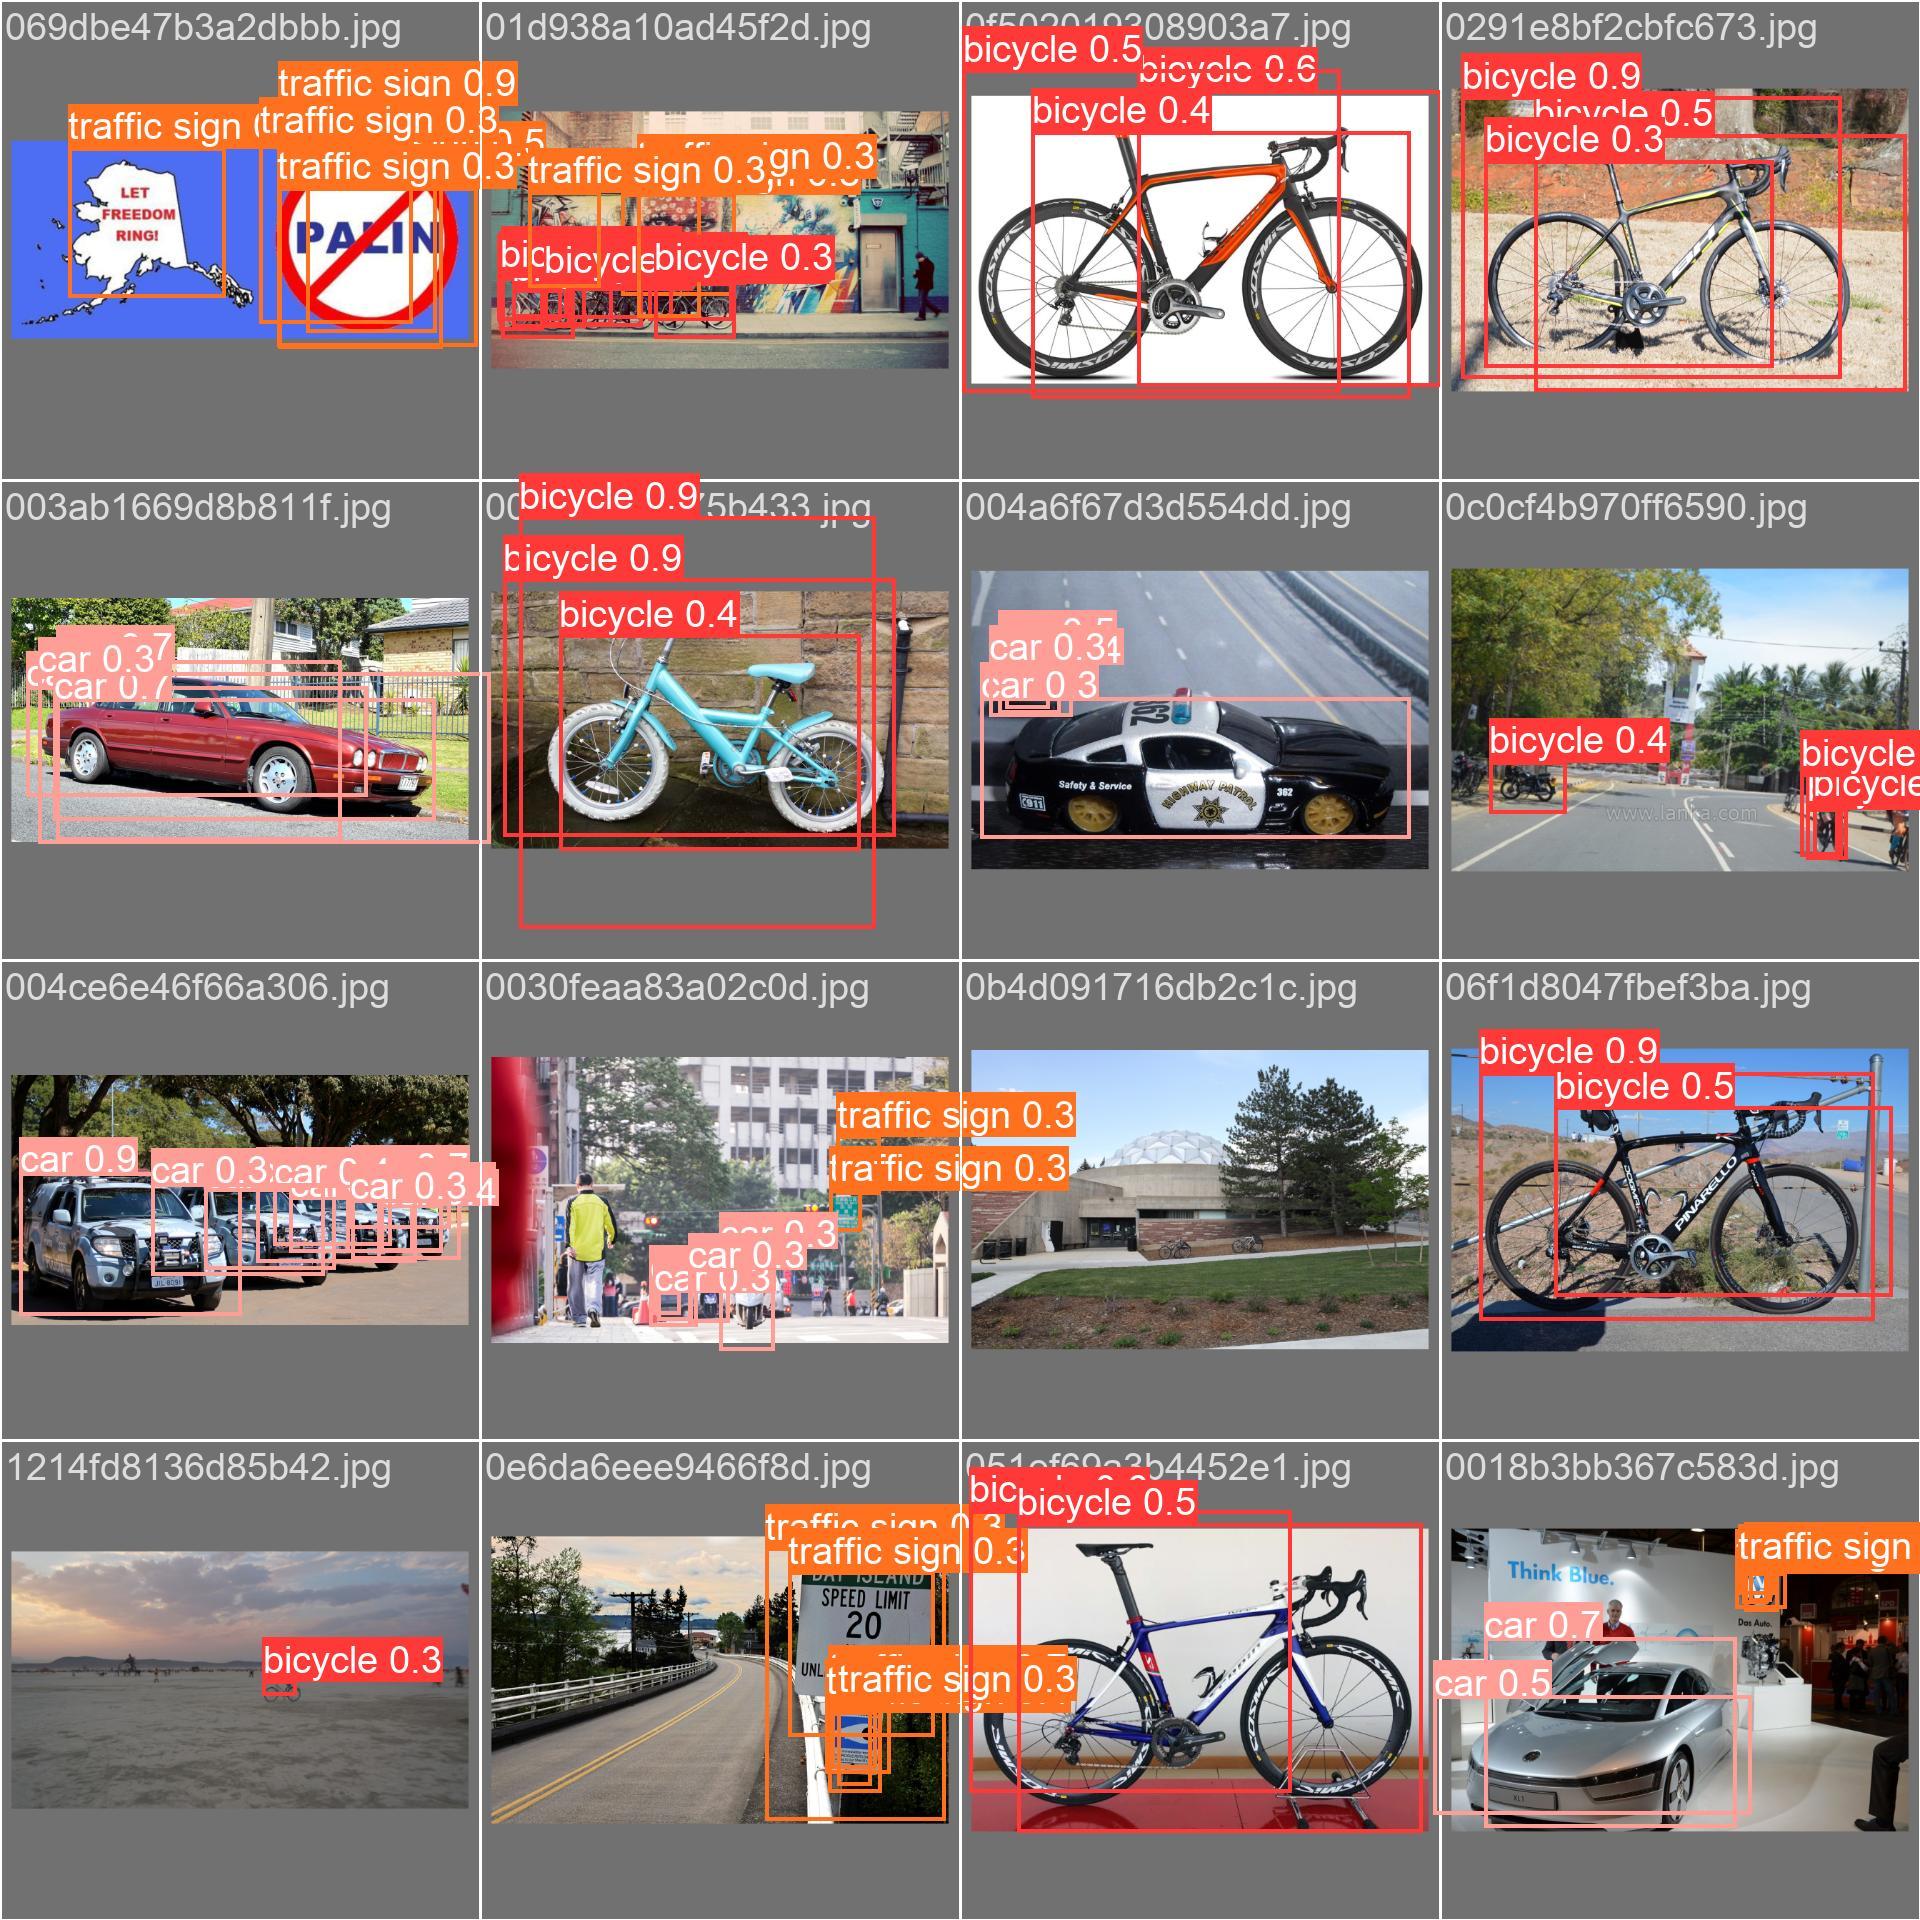

In [6]:
from IPython.display import Image
Image(filename='yolov5/runs/train/exp/val_batch0_pred.jpg', width=700)

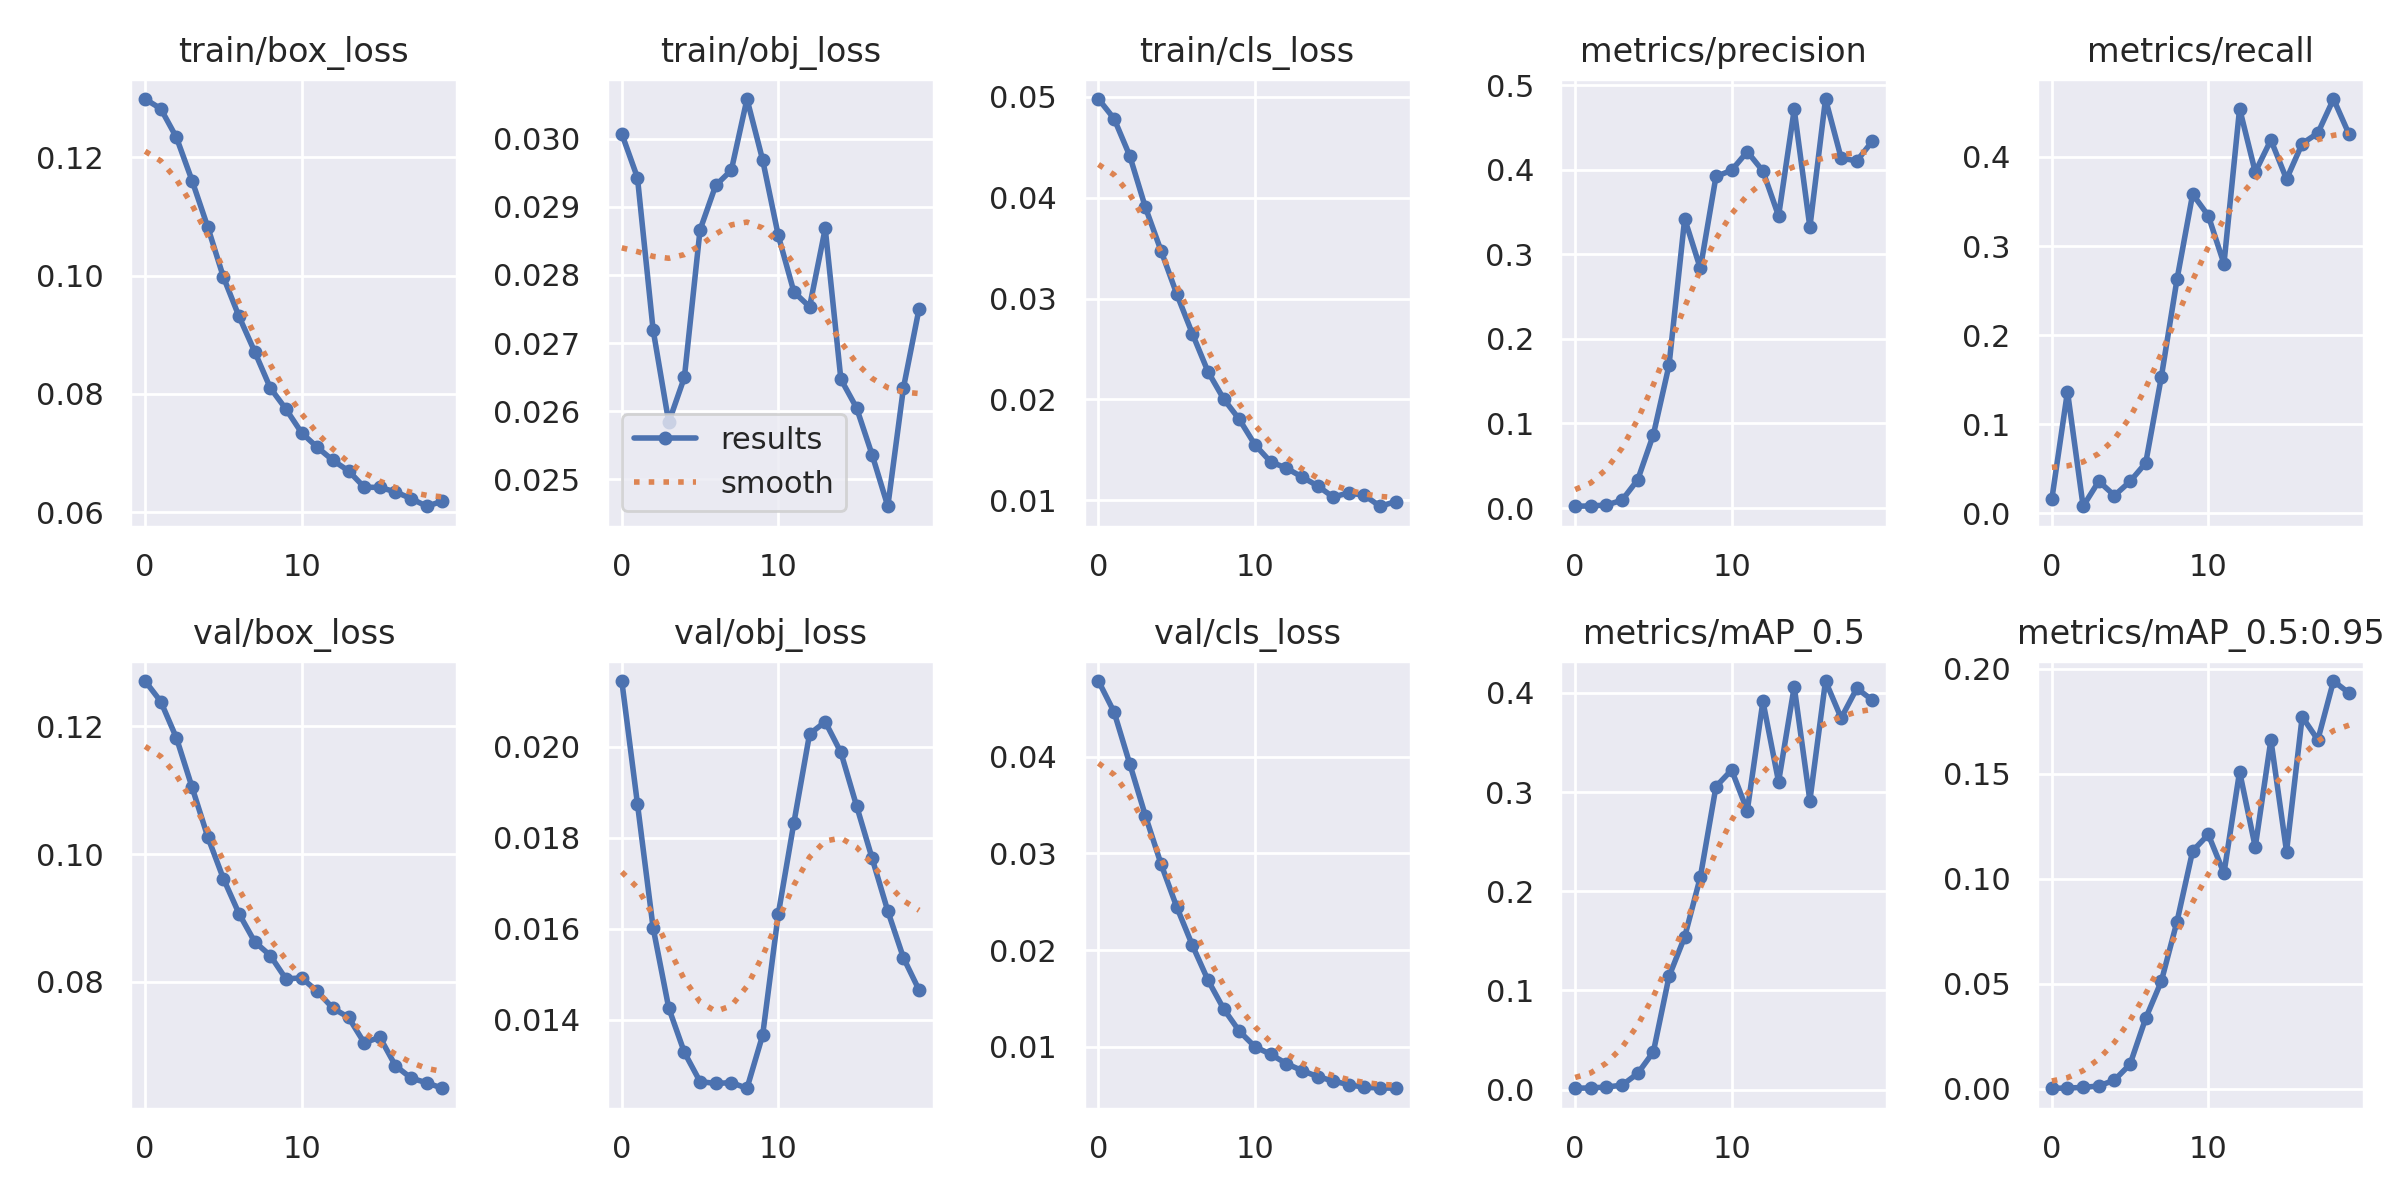

In [7]:
Image(filename='yolov5/runs/train/exp/results.png', width=700)

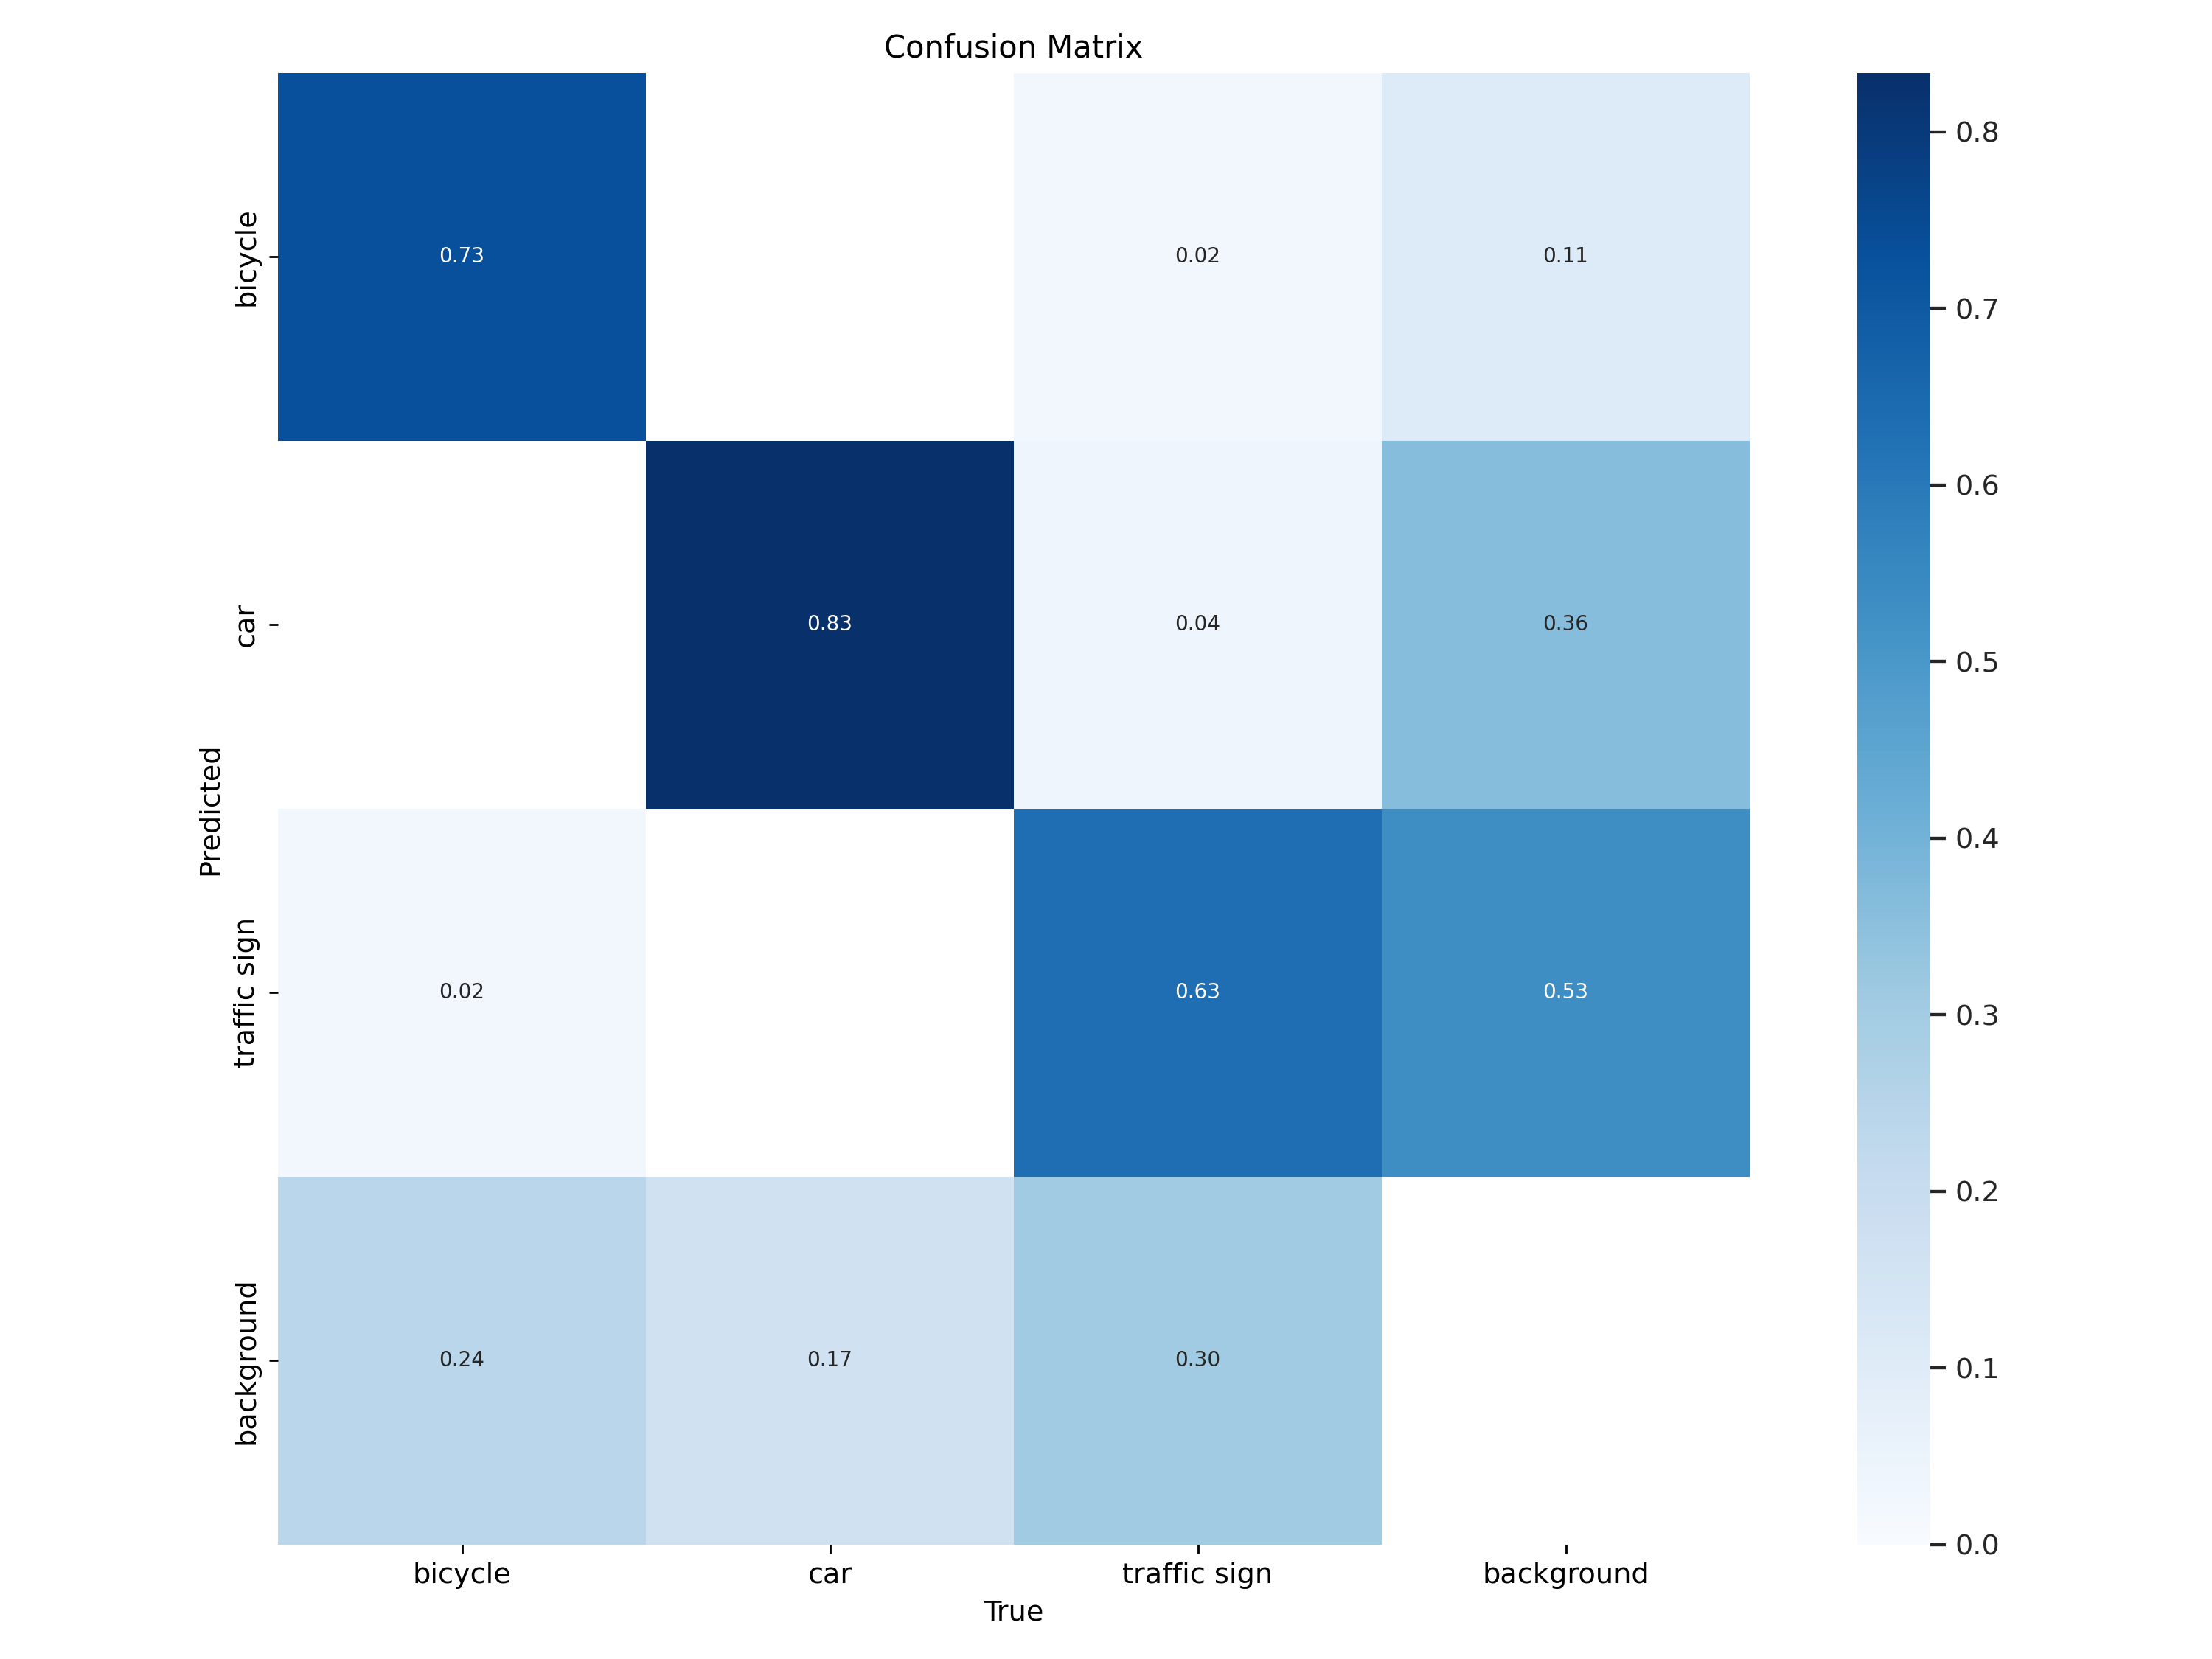

In [8]:
Image(filename='yolov5/runs/train/exp/confusion_matrix.png', width=700)